<a href="https://colab.research.google.com/github/Mkenza/project_DL/blob/master/Labs/TP4-MAKHLOUF-BMDATA2021-autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

**Autoencoders** are a particular type of neural network that compresses the data into a **latent vector**, often denoted $z$ in literature, with the goal of preserving the opportunity to recreate the exact same image in the future. Because autoencoders learn representations instead of labels, autoencoders belong to representation learning, a subfield of machine learning, but not necessarily deep learning.

## Architecture
Autoencoders consist of two networks:

* Encoder
* Decoder

The goal of the **encoder** is to compress an image, video, or any piece of data that can be represented as a tensor, into a _latent vector_. The **decoder** does, as you might have guessed, the exact opposite.

To maximize performance, minimize the loss that is, encoders and decoders are typically symmetrical together. Naturally, the input size is equal to the output size of an autoencoder.

Autoencoders always have less input neurons in the middle layer than in the input and output layer. This is called the **bottleneck**. If it weren't for this bottleneck, the autoencoders could just copy this data over from the input to the output layer without compressing it.

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) [source](https://en.wikipedia.org/wiki/File:Autoencoder_structure.png)

## Training

Encoders and decoders _can_ be trained separately, but usually they are trained in one go. In order to do so, one stacks the coders together in one **stacked autoencoder**.

If one desires to train autoencoders separately, one starts by using the first hidden layer, discaring every other layer, except for the input and output layers of course. He uses the original training data at this point. Next, he uses the latent vector $z$ learnt by this mini-autoencoder and trains another autoencoder in the same way, treating the latent vectors as original data. Once the desired depth is reached, one can stack all output layers, which provided the latent vectors, together in a sinle encoder. This approach is not used in practise a lot, but literature might refer to it as greedy layerwise training so it's good to know what it means.

## Appliciations

While the phase "finding patterns" might not seem very interesting, there are a lot of exciting applications of autoencoders. We will look at three of those today:

1. Dense autoencoder: compressing data.
2. Denoising autoencoder: removing noise from poor training data.
3. Convolutional autoencoder: a building block of DCGANs, self-supervised learning.

While all of these applications use pattern finding, they have different use cases making autoencoders one of the most exciting topics of machine learning.

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from tensorflow import keras

## Loading the data

We will load MNIST, but without labels because representation learning is **unsupervised**, or **self-supervised** which is the prefered term. (https://twitter.com/ylecun/status/1123235709802905600)

In [5]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

11490434/11490434 [==============================] - 2s 0us/step


## A simple autoencoder

Let's start by looking at the simplest possible autoencoder.

The `encoder` is a sequential neural network with $28 \times 28$ input neurons, $100$ neurons in the second layer and $30$ in the third. The third layer is called the "bottleneck". Feel free to play around with this variable to see how it affects results.

In [5]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
])

The decoder is the same, but in opposite order. Note that keras needs to know the input shape at this point. The input shape of the decoder is the shape of $z$, also called `zDim` as you will see later on.

In [6]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

Now stack them for training:

In [ ]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

Note that we use binary cross entropy loss in stead of categorical cross entropy. The reason for that is because we are not classifying latent vectors to belong to a particular class, we do not even have classes!, but rather are trying to predict whether a pixel should be activated or not.

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                   optimizer='adam')

Notice how the $x$ and $y$, both $x$, `x_train` if you like, are equal:

In [ ]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                                  validation_data=[x_test, x_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 89us/sample - loss: 0.1465 - val_loss: 0.1075
Epoch 2/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1032 - val_loss: 0.0983
Epoch 3/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.0981 - val_loss: 0.0950
Epoch 4/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0955 - val_loss: 0.0932
Epoch 5/10
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0935 - val_loss: 0.0919
Epoch 6/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0921 - val_loss: 0.0903
Epoch 7/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0910 - val_loss: 0.0897
Epoch 8/10
60000/60000 [==============================] - 5s 79us/sample - loss: 0.0902 - val_loss: 0.0886
Epoch 9/10
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0894 - val_

Let's look at how the autoencoder reconstructs images.

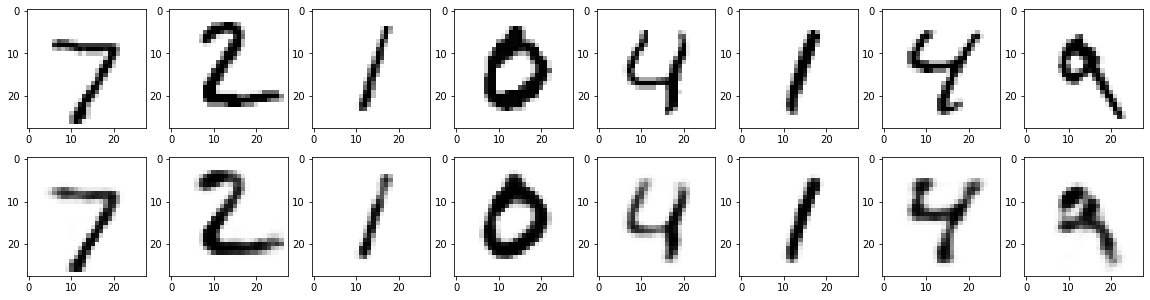

In [ ]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Just from this vector:

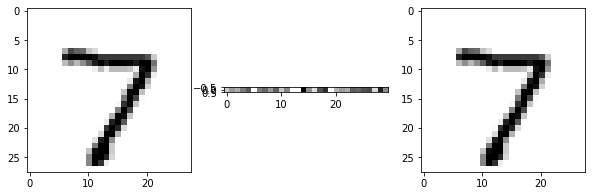

In [ ]:
i = 0 # change this number

figsize(10, 5)

subplot(1, 3, 1)
imshow(x_test[i], cmap="binary")

subplot(1, 3, 2)
latent_vector = encoder.predict(x_test[i].reshape((1, 28, 28)))
imshow(latent_vector, cmap="binary")

subplot(1, 3, 3)
pred = decoder.predict(latent_vector)
imshow(x_test[i], cmap="binary")

In [ ]:
30 / (28 * 28), 1 - 30 / (28 * 28)

(0.03826530612244898, 0.9617346938775511)

That's 96.2% compression! Pretty amazing, huh?

## Denoising autoencoder

The last application of autoencoders we look at today are denoising autoencoders. You probably have no difficulty classifying the images below as 7's.

In [ ]:
import numpy as np

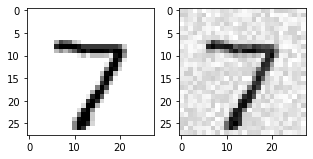

In [ ]:
figsize(5, 10)
subplot(1, 2, 1)
imshow(x_test[0], cmap="binary")

subplot(1, 2, 2)
noise = np.random.random((28, 28)) / 4
imshow(x_test[0] + noise, cmap="binary")

But in machine learning, this noise can be catasrophic. Luckily machine learning also has a solution for this problem: auto encoders!

By applying noise to the images inputted to the encoder and setting the clean image as desired output, $y$, an autoencoder can learn to remove noise from the image.

Let's look at such an encoder:

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu")
])

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [ ]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

Now create a dataset filled with noise:

In [22]:
x_train_noise = x_train + ((np.random.random(x_train.shape)) / 4)
x_test_noise = x_test + ((np.random.random(x_test.shape)) / 4)

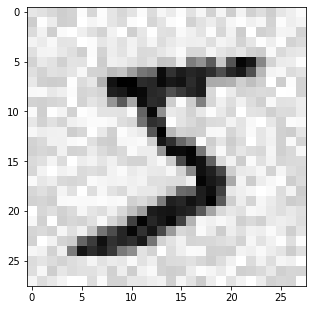

In [ ]:
imshow(x_train_noise[0], cmap="binary")

And finally train the stacked autoencoder with noise input data and clean output data.

In [ ]:
history = stacked_autoencoder.fit(x_train_noise, x_train, epochs=10,
                                  validation_data=[x_test_noise, x_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/sample - loss: 0.1633 - val_loss: 0.1264
Epoch 2/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1206 - val_loss: 0.1130
Epoch 3/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1117 - val_loss: 0.1080
Epoch 4/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1074 - val_loss: 0.1051
Epoch 5/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1049 - val_loss: 0.1031
Epoch 6/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1033 - val_loss: 0.1013
Epoch 7/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.1019 - val_loss: 0.1006
Epoch 8/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.1004 - val_loss: 0.0987
Epoch 9/10
60000/60000 [==============================] - 5s 87us/sample - loss: 0.0991 - val_

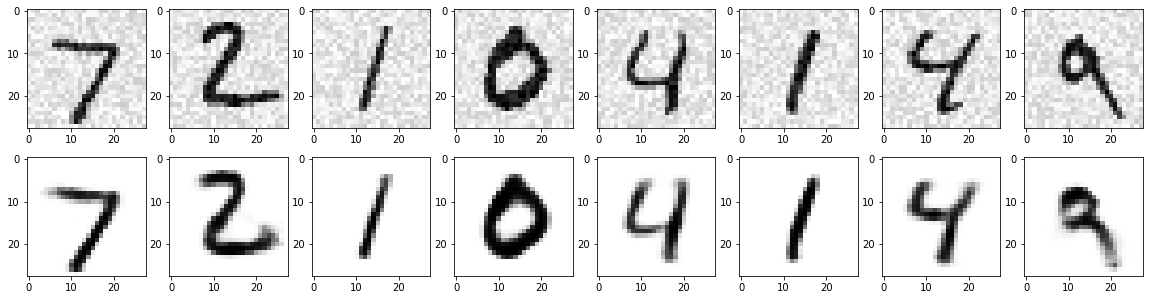

In [ ]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  imshow(x_test_noise[i], cmap="binary")

  subplot(2, 8, i+8+1)
  pred = stacked_autoencoder.predict(x_test_noise[i].reshape((1, 28, 28)))
  imshow(pred.reshape((28, 28)), cmap="binary")

Mindblowing!

## Convolutional autoencoder

Apart from data compression, autoencoders can also be used for self-supervised image classification.

The first layers of the encoder learn to recognize patterns in the data very well in order to compress the data. If you don't have access to much labelled data, but a lot of unlabelled data, it's possible to train an autoencoder and copy the first layers from the autoencoder to the classifier network. This can be compared to transfer learning, where you only have to train the head afterwards.

It is well known that convolutional layers are perfect for finding patterns in data, so it's good to know they can also be used in autoencoders. To "de-convolve" images in the decoder, transposed convolutional layers are used. For more information on transposed convolutional layers, checkout [this blog post](https://rickwierenga.com/blog/s4tf/s4tf-gan.html) I have written which explains them in more detail. See the last section "Autoencoders and GANs" of this notebook for more information on the beautiful relation between GANs and autoencoders.

Let's look at a convolutional encoder:

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

In [23]:
x_train = x_train + ((np.random.random(x_train.shape)) / 4)
x_test = x_test + ((np.random.random(x_test.shape)) / 4)

The weights learnt by this encoder could be copied to the classifier.

In [ ]:
encoder.predict(x_test[0].reshape((1, 28, 28))).shape

(1, 3, 3, 64)

Notice how $z \in \mathbb{R}^{1 \times 3 \times 3 \times 64}$. Now we build its counterpart, the decoder, with transposed convolutional layers to recreate a grayscale $28 \times 28$ image.

In [12]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_18 (Conv2D  (None, 7, 7, 32)         18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 14, 14, 16)       4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 28, 28, 1)        145       
 Transpose)                                                      
                                                                 
 reshape_5 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
__________________________________________________

In [ ]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

In [ ]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                         validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 [==============================] - 16s 7ms/step - loss: 0.3655 - val_loss: 0.3076
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2999 - val_loss: 0.2814
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2822 - val_loss: 0.2690
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2718 - val_loss: 0.2613
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2644 - val_loss: 0.2559
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2600 - val_loss: 0.2518
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2562 - val_loss: 0.2485
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2533 - val_loss: 0.2468
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2509 - val_loss: 0.2444
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - l

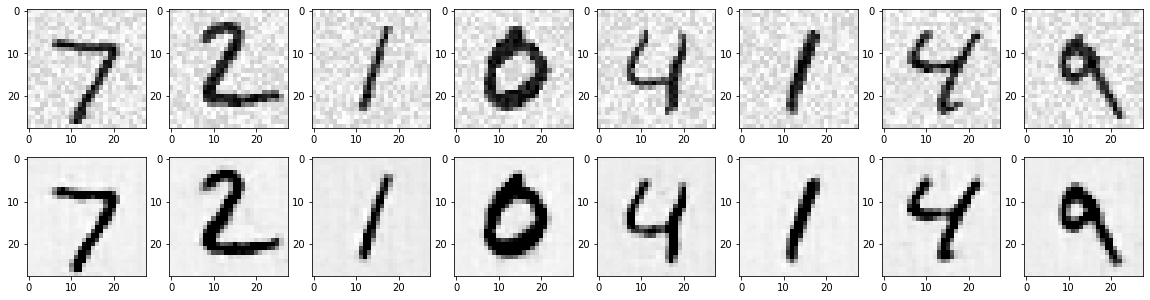

In [ ]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

### Auto-encoder with pretrained encoder

Les images sont en grayscale (n_channels=1), on peut utiliser cv2 pour les rendre en rgb, ou concatener les images pour avoir 3 canaux (28, 28, 3):

In [6]:
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_train_rgb = np.concatenate((x_train_reshaped, x_train_reshaped, x_train_reshaped), axis=3)

In [7]:
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_test_rgb = np.concatenate((x_test_reshaped, x_test_reshaped, x_test_reshaped), axis=3)

Pour mettre les images dans le bon format (224, 224), on ajoute une layer keras de resizing, afin de profiter du GPU, et on enchaîne avec un encodeur VGG16 dont la partie dense est supprimée, puis un decoder personnalisé, pour avoir l'image en sortie (28, 28):

In [8]:
from tensorflow.keras.applications import VGG16

batch_size=32
preprocessing = keras.layers.Resizing(32, 32, input_shape=[28, 28, 3])

encoder = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[1, 1, 512]),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Resizing(28, 28),
    keras.layers.Reshape([28, 28])
])

stacked_autoencoder = keras.models.Sequential([preprocessing, encoder, decoder])
stacked_autoencoder.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 28, 28)            147777    
                                                                 
Total params: 14,862,465
Trainable params: 14,862,465
Non-trainable params: 0
_________________________________________________________________


In [9]:
stacked_autoencoder.compile(loss="binary_crossentropy", optimizer='adam')

In [10]:
history = stacked_autoencoder.fit(x_train_rgb, x_train, epochs=10,
                         validation_data=[x_test_rgb, x_test])

Epoch 1/10
1875/1875 [==============================] - 64s 29ms/step - loss: 0.3236 - val_loss: 0.3094
Epoch 2/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3082 - val_loss: 0.3078
Epoch 3/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.3074 - val_loss: 0.3078
Epoch 4/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.2053 - val_loss: 0.1998
Epoch 5/10
1875/1875 [==============================] - 55s 30ms/step - loss: 0.1997 - val_loss: 0.1995
Epoch 6/10
1875/1875 [==============================] - 55s 30ms/step - loss: 0.1992 - val_loss: 0.1970
Epoch 7/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1968 - val_loss: 0.1965
Epoch 8/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1965 - val_loss: 0.1964
Epoch 9/10
1875/1875 [==============================] - 55s 29ms/step - loss: 0.1964 - val_loss: 0.1964
Epoch 10/10
1875/1875 [==============================] - 57s 31m

1/1 [==============================] - 0s 16ms/step


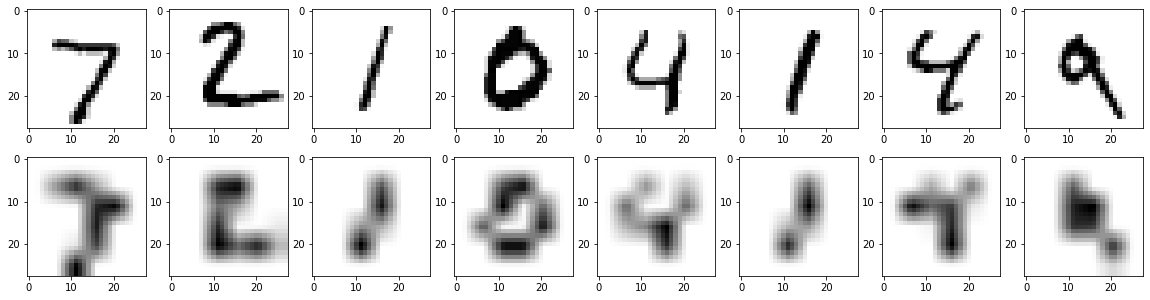

In [21]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test_rgb[i].reshape(1, 28, 28, 3))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Nous avons des résultats moins intéressants que les résultats précédents. Pour certaines applications (assez rares), l'usage d'un modèles pré-entraîné n'est pas la meilleure solution. Ici, le modèle a du apprendre 15Millions de paramètres à partir de 6000 images. Le modèle n'a pas pu apprendre assez (underfitting), même si la loss est bien inférieure à 0.2

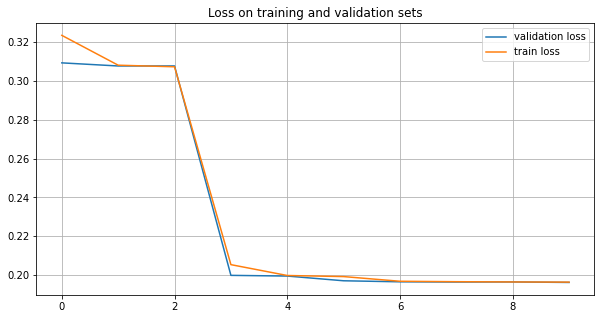

In [20]:
figsize(10, 5)

plot(history.history["val_loss"], label="validation loss")
plot(history.history["loss"], label="train loss")
title("Loss on training and validation sets")
legend()
grid()
show()